<a href="https://colab.research.google.com/github/nikitos-net/Machine-learning-methods-for-automatic-recognition-of-fake-faces./blob/main/xception_deepfake_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.9 MB/s eta 0:00:00
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any

In [ ]:
"""
Ported to pytorch thanks to [tstandley](https://github.com/tstandley/Xception-PyTorch)

@author: tstandley
Adapted by cadene

Creates an Xception Model as defined in:

Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf

This weights ported from the Keras implementation. Achieves the following performance on the validation set:

Loss:0.9173 Prec@1:78.892 Prec@5:94.292

REMEMBER to set your image size to 3x299x299 for both test and validation

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

pretrained_settings = {
    'xception': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000,
            'scale': 0.8975 # The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
        }
    }
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = self.relu(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def xception(num_classes=1000, pretrained='imagenet'):
    model = Xception(num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['xception'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        model = Xception(num_classes=num_classes)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']

    # TODO: ugly
    model.last_linear = model.fc
    del model.fc
    return model

In [ ]:
import os
import argparse


import torch
import pretrainedmodels
import torch.nn as nn
import torch.nn.functional as F
#from network.xception import xception
import math
import torchvision


def return_pytorch04_xception(pretrained=True):
    # Raises warning "src not broadcastable to dst" but thats fine
    model = xception(pretrained=False)
    if pretrained:
        # Load model in torch 0.4+
        model.fc = model.last_linear
        del model.last_linear
        state_dict = torch.load(
            '/content/drive/MyDrive/models/xception-b5690688.pth')
        for name, weights in state_dict.items():
            if 'pointwise' in name:
                state_dict[name] = weights.unsqueeze(-1).unsqueeze(-1)
        model.load_state_dict(state_dict)
        model.last_linear = model.fc
        del model.fc
    return model


class TransferModel(nn.Module):
    """
    Simple transfer learning model that takes an imagenet pretrained model with
    a fc layer as base model and retrains a new fc layer for num_out_classes
    """
    def __init__(self, modelchoice, num_out_classes=2, dropout=0.0):
        super(TransferModel, self).__init__()
        self.modelchoice = modelchoice
        if modelchoice == 'xception':
            self.model = return_pytorch04_xception()
            # Replace fc
            num_ftrs = self.model.last_linear.in_features
            if not dropout:
                self.model.last_linear = nn.Linear(num_ftrs, num_out_classes)
            else:
                print('Using dropout', dropout)
                self.model.last_linear = nn.Sequential(
                    nn.Dropout(p=dropout),
                    nn.Linear(num_ftrs, num_out_classes)
                )
        elif modelchoice == 'resnet50' or modelchoice == 'resnet18':
            if modelchoice == 'resnet50':
                self.model = torchvision.models.resnet50(pretrained=True)
            if modelchoice == 'resnet18':
                self.model = torchvision.models.resnet18(pretrained=True)
            # Replace fc
            num_ftrs = self.model.fc.in_features
            if not dropout:
                self.model.fc = nn.Linear(num_ftrs, num_out_classes)
            else:
                self.model.fc = nn.Sequential(
                    nn.Dropout(p=dropout),
                    nn.Linear(num_ftrs, num_out_classes)
                )
        else:
            raise Exception('Choose valid model, e.g. resnet50')

    def set_trainable_up_to(self, boolean, layername="Conv2d_4a_3x3"):
        """
        Freezes all layers below a specific layer and sets the following layers
        to true if boolean else only the fully connected final layer
        :param boolean:
        :param layername: depends on network, for inception e.g. Conv2d_4a_3x3
        :return:
        """
        # Stage-1: freeze all the layers
        if layername is None:
            for i, param in self.model.named_parameters():
                param.requires_grad = True
                return
        else:
            for i, param in self.model.named_parameters():
                param.requires_grad = False
        if boolean:
            # Make all layers following the layername layer trainable
            ct = []
            found = False
            for name, child in self.model.named_children():
                if layername in ct:
                    found = True
                    for params in child.parameters():
                        params.requires_grad = True
                ct.append(name)
            if not found:
                raise Exception('Layer not found, cant finetune!'.format(
                    layername))
        else:
            if self.modelchoice == 'xception':
                # Make fc trainable
                for param in self.model.last_linear.parameters():
                    param.requires_grad = True

            else:
                # Make fc trainable
                for param in self.model.fc.parameters():
                    param.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return x


def model_selection(modelname, num_out_classes,
                    dropout=None):
    """
    :param modelname:
    :return: model, image size, pretraining<yes/no>, input_list
    """
    if modelname == 'xception':
        return TransferModel(modelchoice='xception',
                             num_out_classes=num_out_classes), 299, \
               True, ['image'], None
    elif modelname == 'resnet18':
        return TransferModel(modelchoice='resnet18', dropout=dropout,
                             num_out_classes=num_out_classes), \
               224, True, ['image'], None
    else:
        raise NotImplementedError(modelname)

In [ ]:
from torchvision import transforms

xception_default_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ]),
    'test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ]),
}

In [ ]:
def preprocess_image(image, cuda=True):
    """
    Preprocesses the image such that it can be fed into our network.
    During this process we envoke PIL to cast it into a PIL image.

    :param image: numpy image in opencv form (i.e., BGR and of shape
    :return: pytorch tensor of shape [1, 3, image_size, image_size], not
    necessarily casted to cuda
    """
    # Revert from BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Preprocess using the preprocessing function used during training and
    # casting it to PIL image
    preprocess = xception_default_data_transforms['test']
    preprocessed_image = preprocess(pil_image.fromarray(image))
    # Add first dimension as the network expects a batch
    preprocessed_image = preprocessed_image.unsqueeze(0)
    if cuda:
        preprocessed_image = preprocessed_image.cuda()
    return preprocessed_image

def predict_with_model(image, model, post_function=nn.Softmax(dim=1),
                       cuda=True):
    """
    Predicts the label of an input image. Preprocesses the input image and
    casts it to cuda if required

    :param image: numpy image
    :param model: torch model with linear layer at the end
    :param post_function: e.g., softmax
    :param cuda: enables cuda, must be the same parameter as the model
    :return: prediction (1 = fake, 0 = real)
    """
    # Preprocess
    preprocessed_image = preprocess_image(image, cuda)

    # Model prediction
    output = model(preprocessed_image)
    output = post_function(output)

    # Cast to desired
    _, prediction = torch.max(output, 1)    # argmax
    prediction = float(prediction.cpu().numpy()[0])

    return int(prediction), output

def process_images(image_dir, label, image_limit=None):
        image_count = 0
        for filename in os.listdir(image_dir):
            if image_limit is not None and image_count >= image_limit:
                break  # Достигли лимита изображений
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Проверка расширения файла
                image_path = os.path.join(image_dir, filename)
                try:
                    image = cv2.imread(image_path)
                    if image is None:
                        raise FileNotFoundError(f"Не удалось загрузить изображение по пути: {image_path}")
                except FileNotFoundError as e:
                    print(e)
                    continue  # Пропускаем это изображение
                except Exception as e:
                    print(f"Ошибка при загрузке изображения: {e}")
                    continue

                try:
                    prediction, output = predict_with_model(image, model, cuda=cuda_available)
                    all_labels.append(label)
                    all_probabilities.append(output[0, 1].item())  # Вероятность класса "фейк" (1)
                    image_count += 1
                except Exception as e:
                    print(f"Ошибка при предсказании изображения {filename}: {e}")

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image as pil_image
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    """PyTorch Dataset для загрузки изображений из директории."""

    def __init__(self, image_dir, transform=None, num_images=None):
        self.image_dir = image_dir
        self.image_paths = []
        for filename in os.listdir(image_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(image_dir, filename))

        if num_images is not None:
            self.image_paths = self.image_paths[:num_images] # Ограничиваем количество изображений

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Не удалось загрузить изображение по пути: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB
        except FileNotFoundError as e:
            print(e)
            return None #  Обрабатываем ошибку, возвращая None
        except Exception as e:
            print(f"Ошибка при загрузке изображения: {e}")
            return None

        if self.transform:
            image = pil_image.fromarray(image)
            image = self.transform(image)

        return image, image_path # Возвращаем также путь к изображению

def test_model(model, fake_dir, real_dir, image_size, batch_size=32, num_images=None, cuda_available=False):
    """
    Тестирует модель на изображениях из папок fake и real, считает AUC и строит ROC кривую.
    Добавлена пакетная обработка и индикатор выполнения.

    Args:
        model: PyTorch модель для тестирования.
        fake_dir: Путь к папке с фейковыми изображениями.
        real_dir: Путь к папке с реальными изображениями.
        image_size: Размер изображения, к которому нужно привести вход. Не используется, но оставлен для совместимости.
        batch_size: Размер пакета для пакетной обработки.
        num_images: Максимальное количество изображений для тестирования (из каждой папки). Если None, используются все.
        cuda_available: True, если CUDA доступна, иначе False.

    Returns:
        None.  Выводит AUC и строит ROC кривую.
    """

    model.eval()  # Устанавливаем модель в режим оценки
    if cuda_available:
        model = model.cuda() # Переносим модель на GPU, если доступна

    all_labels = []
    all_probabilities = []

    # Создаем Dataset и DataLoader для fake images
    fake_dataset = ImageDataset(fake_dir, transform=xception_default_data_transforms['test'], num_images=num_images)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False)

    # Создаем Dataset и DataLoader для real images
    real_dataset = ImageDataset(real_dir, transform=xception_default_data_transforms['test'], num_images=num_images)
    real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)


    # Обработка фейковых изображений
    print("Обработка фейковых изображений...")
    for images, image_paths in tqdm(fake_loader, desc="Fake Images"):
        # Пропускаем пустые батчи (где все изображения не загрузились)
        valid_images = [image for image in images if image is not None]  # Отфильтровываем None
        valid_image_paths = [path for image, path in zip(images, image_paths) if image is not None] # фильтруем пути

        if len(valid_images) == 0:
            continue

        if cuda_available:
            images = torch.stack(valid_images).cuda()
        else:
            images = torch.stack(valid_images)

        try:
            with torch.no_grad():
                #image = preprocess_image(image, cuda)
                output = model(images)
                probabilities = torch.softmax(output, dim=1).cpu().numpy()
                #predictions = torch.argmax(output, dim=1).cpu().numpy() #  Не используем предсказания, только вероятности
            all_labels.extend([1] * len(valid_images))  # Фейк = 1
            all_probabilities.extend(probabilities[:, 1].tolist())  # Вероятность класса "фейк" (1)
        except Exception as e:
            print(f"Ошибка при предсказании пакета фейковых изображений: {e}")

    # Обработка реальных изображений
    print("Обработка реальных изображений...")
    for images, image_paths in tqdm(real_loader, desc="Real Images"):

        valid_images = [image for image in images if image is not None]
        valid_image_paths = [path for image, path in zip(images, image_paths) if image is not None]

        if len(valid_images) == 0:
            continue

        if cuda_available:
            images = torch.stack(valid_images).cuda()
        else:
            images = torch.stack(valid_images)


        try:
            with torch.no_grad():
                #image = preprocess_image(image, cuda)
                output = model(images)
                probabilities = torch.softmax(output, dim=1).cpu().numpy()
            all_labels.extend([0] * len(valid_images))  # Реал = 0
            all_probabilities.extend(probabilities[:, 1].tolist())  # Вероятность класса "фейк" (1)
        except Exception as e:
            print(f"Ошибка при предсказании пакета реальных изображений: {e}")

    # 3. Вычисление AUC
    try:
        auc = roc_auc_score(all_labels, all_probabilities)
        print(f"\nAUC: {auc}")
    except ValueError as e:
        print(f"Ошибка при вычислении AUC: {e}.  Убедитесь, что в обеих папках есть изображения.")
        return

    # 4. Построение ROC кривой
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import cv2
from PIL import Image as pil_image  # Переименуем для ясности
import torchvision.transforms as transforms
import numpy as np

In [ ]:
model, image_size, *_ = model_selection('xception', num_out_classes=2)
#model = model.cuda()
from torchsummary import summary
input_s = (3, image_size, image_size)
print(summary(model, input_s))

model.eval() # Важно перевести в режим оценки

<ipython-input-3-f8972f2ce1a3>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
              ReLU-6         [-1, 64, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]             576
            Conv2d-8        [-1, 128, 147, 147]           8,192
   SeparableConv2d-9        [-1, 128, 147, 147]               0
      BatchNorm2d-10        [-1, 128, 147, 147]             256
             ReLU-11        [-1, 128, 147, 147]               0
             ReLU-12        [-1, 128, 147, 147]               0
           Conv2d-13        [-1, 128, 147, 147]           1,152
           Conv2d-14        [-1, 128, 1

TransferModel(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [ ]:
from huggingface_hub import hf_hub_download, list_repo_files
import os
import tarfile

repo_id = "xingjunm/WildDeepfake"
fake_dir = "deepfake_in_the_wild/fake_test"
real_dir = "deepfake_in_the_wild/real_test"
local_dir = "downloaded_data"
fake_images_folder = "extracted_fake_images"
real_images_folder = "extracted_real_images"

os.makedirs(local_dir, exist_ok=True)
os.makedirs(fake_images_folder, exist_ok=True)
os.makedirs(real_images_folder, exist_ok=True)

files = list_repo_files(repo_id, repo_type="dataset")

for file_path in files:
    target_folder = None
    if file_path.startswith(fake_dir):
        target_folder = fake_dir
        output_folder = fake_images_folder
    elif file_path.startswith(real_dir):
        target_folder = real_dir
        output_folder = real_images_folder

    if target_folder:
        local_file_path = os.path.join(local_dir, file_path[len(target_folder) + 1:])
        try:
            print(f"Скачиваем {file_path}...")
            download_path = hf_hub_download(repo_id, filename=file_path, repo_type="dataset", local_dir=local_dir)
            file_size = os.path.getsize(download_path)
            print(f"  Файл скачан, размер: {file_size} байт")

            if file_path.endswith(".tar.gz"):
                print(f"  Распаковываем {file_path} как tar (без gzip)...")
                try:
                    with tarfile.open(download_path, 'r') as tar_ref:
                        for member in tar_ref.getmembers():
                            if not member.isdir() and any(member.name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
                                try:
                                    image_file = tar_ref.extractfile(member)
                                    if image_file:
                                        image_data = image_file.read()
                                        local_image_path = os.path.join(output_folder, os.path.basename(member.name))
                                        with open(local_image_path, "wb") as f:
                                            f.write(image_data)
                                        #print(f"    Извлечено изображение: {member.name}")
                                except Exception as e:
                                    print(f"    Ошибка при извлечении изображения {member.name}: {e}")
                except Exception as e:
                    print(f"  Ошибка при распаковке архива {file_path}: {e}")
            else:
                print(f"  Файл {file_path} не является архивом tar.gz, пропущен")

            print(f"  Файл {file_path} обработан.")

        except Exception as e:
            print(f"Ошибка при скачивании файла {file_path}: {e}")

print("Загрузка и распаковка завершены.")

In [ ]:
rm -r /content/downloaded_data

False
Обработка фейковых изображений...


Fake Images: 100%|██████████| 128/128 [57:18<00:00, 26.87s/it]


Обработка реальных изображений...


Real Images: 100%|██████████| 128/128 [56:23<00:00, 26.43s/it]



AUC: 0.5522024929523468


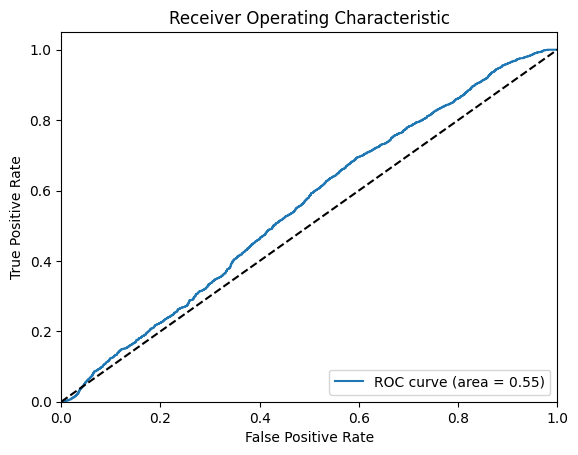

In [ ]:

# 3. Проверьте, доступна ли CUDA
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu") # Определяем устройство
print(cuda_available)
# Если CUDA доступна, переместите модель на GPU
if cuda_available:
    model.cuda()  # Переместите модель на GPU



# 5. Пути к данным (ЗАМЕНИТЕ, если пути отличаются)
fake_images_folder = "/content/extracted_fake_images"
real_images_folder = "/content/extracted_real_images"

# 7. Запуск тестирования
try:
    test_model(model, fake_images_folder, real_images_folder, image_size, batch_size=32, num_images=4096, cuda_available=cuda_available)

except Exception as e:
    print(f"Ошибка во время тестирования: {e}")

In [ ]:
image_path = "/content/1471.png"
try:
    image = cv2.imread(image_path)  # Загружаем с помощью cv2, как указано в preprocess_image
    if image is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение по пути: {image_path}")
except FileNotFoundError as e:
    print(e)
    exit()
except Exception as e:
    print(f"Ошибка при загрузке изображения: {e}")
    exit()

# 4. Сделайте предсказание
try:
    prediction, output = predict_with_model(image, model, cuda=cuda_available) # Используем cuda_available

    print(f"Предсказание: {prediction} (0 = реальное, 1 = фейк)")
    print(f"Выходные вероятности: {output}")

except Exception as e:
    print(f"Ошибка во время предсказания: {e}")
    exit()

Предсказание: 0 (0 = реальное, 1 = фейк)
Выходные вероятности: tensor([[0.5077, 0.4923]], grad_fn=<SoftmaxBackward0>)
